In [1]:
'''
Coding: PYTHON UTF-8
Created On: 2024-01-22 15:58:08
Author: Putu Hendra Widyadharma
=== Make histogram of uncertainty lat, lon, and depth of Bootstrap technique
=== input *.reloc
'''

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import glob
from tkinter import Tcl
from pathlib import Path
import os
%matplotlib inline

In [2]:
# setting absolute (make difference to positive only)
absolute_value = False

# setting path
path = "G:/My Drive/Tomography/220124/tes1-bts-sum-29062022/"

# locate file
relocs = glob.glob(os.path.join(path,'*.reloc'))
# find file and calculate filelength
relocs = list(Tcl().call('lsort', '-dict', relocs))
relocs_flength = [len(open(x, 'r').readlines()) for x in relocs]
# find filename
min_filename = Path(relocs[relocs_flength.index(min(relocs_flength))]).name
max_filename = Path(relocs[relocs_flength.index(max(relocs_flength))]).name
# make reloc_iterable
reloc_iterable = relocs.copy()
reloc_iterable.remove(reloc_iterable[relocs_flength.index(min(relocs_flength))])

# output 
print(f"number of .reloc file = {len(relocs)}")
print(f"minimum file length = {min(relocs_flength)} on {min_filename}")
print(f"maximum file length = {max(relocs_flength)} on {max_filename}")

number of .reloc file = 49
minimum file length = 4863 on tomo.reloc
maximum file length = 5450 on tomo27.reloc


In [3]:
# read base event list and create LAT, LON, and DEPTH container
reloc = pd.read_csv(os.path.join(path,f"{Path(relocs[relocs_flength.index(max(relocs_flength))]).name}"), delim_whitespace=True, index_col=False, header=None,\
    names="ID, LAT, LON, DEPTH, X, Y, Z, EX, EY, EZ, YR, MO, DY, HR, MI, SC, MAG, NCCP, NCTP, NCTS, RCC, RCT, CID, UNKNOWN".replace(" ","").split(","))
lon_df = reloc[['ID','LON']].copy()
lon_df = lon_df.rename(columns={'LON': f'{max_filename}'})
lat_df = reloc[['ID','LAT']].copy()
lat_df = lat_df.rename(columns={'LAT': f'{max_filename}'})
depth_df = reloc[['ID','DEPTH']].copy()
depth_df = depth_df.rename(columns={'DEPTH': f'{max_filename}'})

In [4]:
# processing entire data to get df per items (lat,lon,depth)
for reloc in relocs:
    reloc_tmp = pd.read_csv(os.path.join(path,f"{reloc}"), delim_whitespace=True, index_col=False, header=None,\
        names="ID, LAT, LON, DEPTH, X, Y, Z, EX, EY, EZ, YR, MO, DY, HR, MI, SC, MAG, NCCP, NCTP, NCTS, RCC, RCT, CID, UNKNOWN".replace(" ","").split(","))
    lon_tmp = reloc_tmp[['ID','LON']]
    lon_df = pd.merge(lon_df,lon_tmp,how='left',on='ID')
    lon_df = lon_df.rename(columns={'LON': f'{Path(reloc).name}'})
    lat_tmp = reloc_tmp[['ID','LAT']]
    lat_df = pd.merge(lat_df,lat_tmp,how='left',on='ID')
    lat_df = lat_df.rename(columns={'LAT': f'{Path(reloc).name}'})
    depth_tmp = reloc_tmp[['ID','DEPTH']]
    depth_df = pd.merge(depth_df,depth_tmp,how='left',on='ID')
    depth_df = depth_df.rename(columns={'DEPTH': f'{Path(reloc).name}'})

# save mining data default value
lon_df.to_csv(path+"grab_lon.csv", index=None)
lat_df.to_csv(path+"grab_lat.csv", index=None)
depth_df.to_csv(path+"grab_depth.csv", index=None)

# manipulate data to get difference over columns
base_value_lon = lon_df.iloc[:,1].copy()
base_value_lat = lat_df.iloc[:,1].copy()
base_value_depth = depth_df.iloc[:,1].copy()
for i in range(1,len(lon_df.columns)):
    lon_df.iloc[:,i] = lon_df.iloc[:,i] - base_value_lon
    lat_df.iloc[:,i] = lat_df.iloc[:,i] - base_value_lat
    depth_df.iloc[:,i] = depth_df.iloc[:,i] - base_value_depth

# convert degree to km 
lon_df.iloc[:,1:] *= 111
lat_df.iloc[:,1:] *= 111

# get average difference per ID
lon_df['avg'] = lon_df.iloc[:,1:].mean(axis=1,skipna=True)
lat_df['avg'] = lat_df.iloc[:,1:].mean(axis=1,skipna=True)
depth_df['avg'] = depth_df.iloc[:,1:].mean(axis=1,skipna=True)


In [5]:
# calculate resultant 
df_resultant = pd.DataFrame([],columns=['ID','res_distance','res_theta_degree', 'res_phi_degree'])
df_resultant['ID'] = lon_df['ID'].copy()

df_resultant['res_distance'] = np.sqrt((lon_df['avg']*10)**2+(lat_df['avg']*10)**2+(depth_df['avg']*10)**2)
df_resultant['res_theta_degree'] = np.rad2deg(np.arctan2(depth_df['avg'],((lon_df['avg']*10)**2+(lat_df['avg']*10)**2)))
df_resultant['res_phi_degree'] = np.rad2deg(np.arctan2(lat_df['avg']*10,lon_df['avg']*10))

In [7]:
df_resultant.to_csv(path+"resultant.csv", index=None)

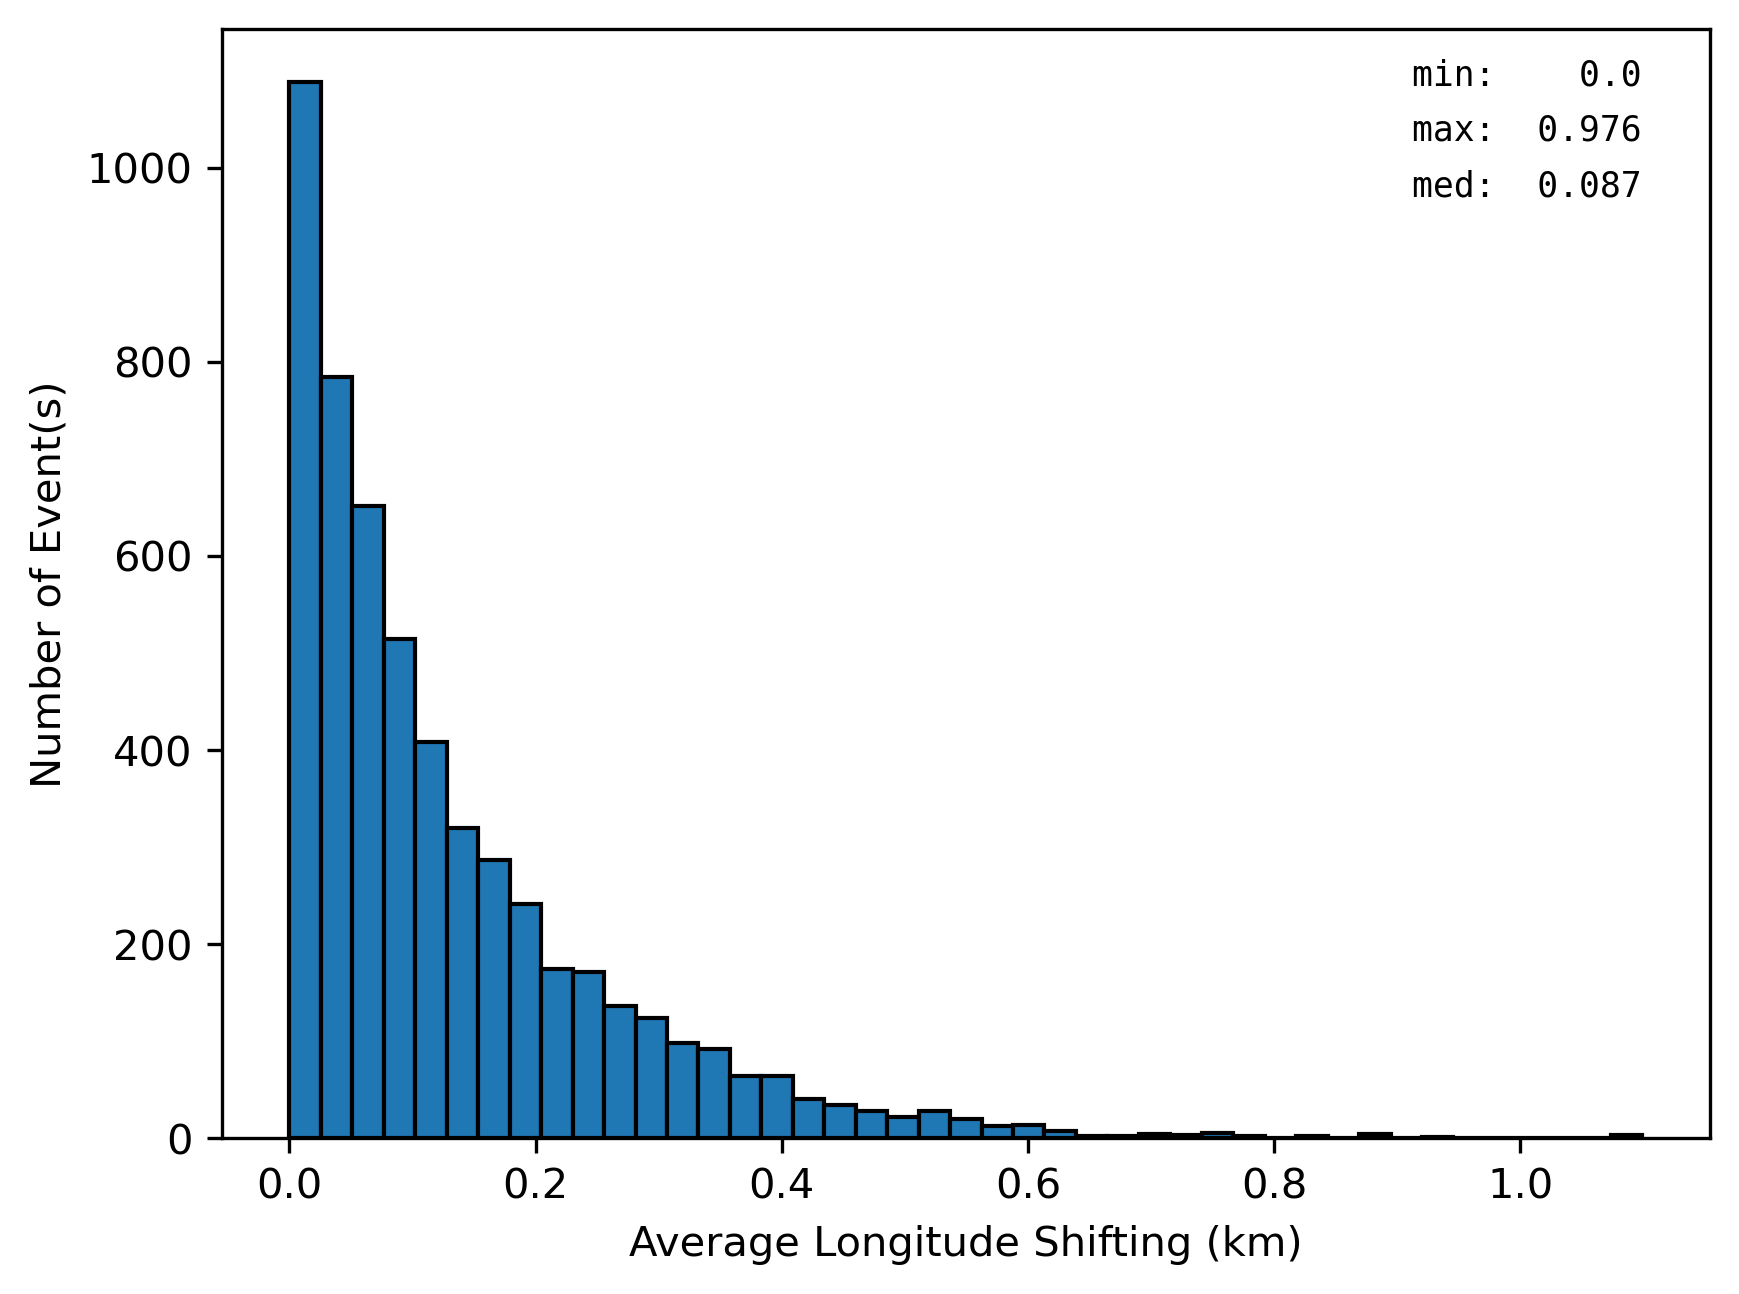

In [14]:
# plotting data to histogram
fig, ax = plt.subplots(dpi = 300)

#calculate min max avg
max = round(lat_df['avg'].max(),3)
min = round(lat_df['avg'].min(),3)
med = round(lat_df['avg'].median(),3)

# plot histogram
if absolute_value:
    #calculate min max avg
    max = round(lat_df['avg'].abs().max(),3)
    min = round(lat_df['avg'].abs().min(),3)
    med = round(lat_df['avg'].abs().median(),3)
    ax.hist(lon_df['avg'].abs(),bins='scott',edgecolor='black',align='mid')
else:
    #calculate min max avg
    max = round(lat_df['avg'].max(),3)
    min = round(lat_df['avg'].min(),3)
    med = round(lat_df['avg'].median(),3)
    ax.hist(lon_df['avg'],bins='scott',edgecolor='black',align='mid')

# plot min max avg
ax.text(0.8,0.95,f"min: {min:>6}", size = "small", family= "monospace", transform=ax.transAxes)
ax.text(0.8,0.90,f"max: {max:>6}", size = "small", family= "monospace", transform=ax.transAxes)
ax.text(0.8,0.85,f"med: {med:>6}", size = "small", family= "monospace", transform=ax.transAxes)

ax.set_xlabel('Average Longitude Shifting (km)')
ax.set_ylabel('Number of Event(s)')
plt.show()

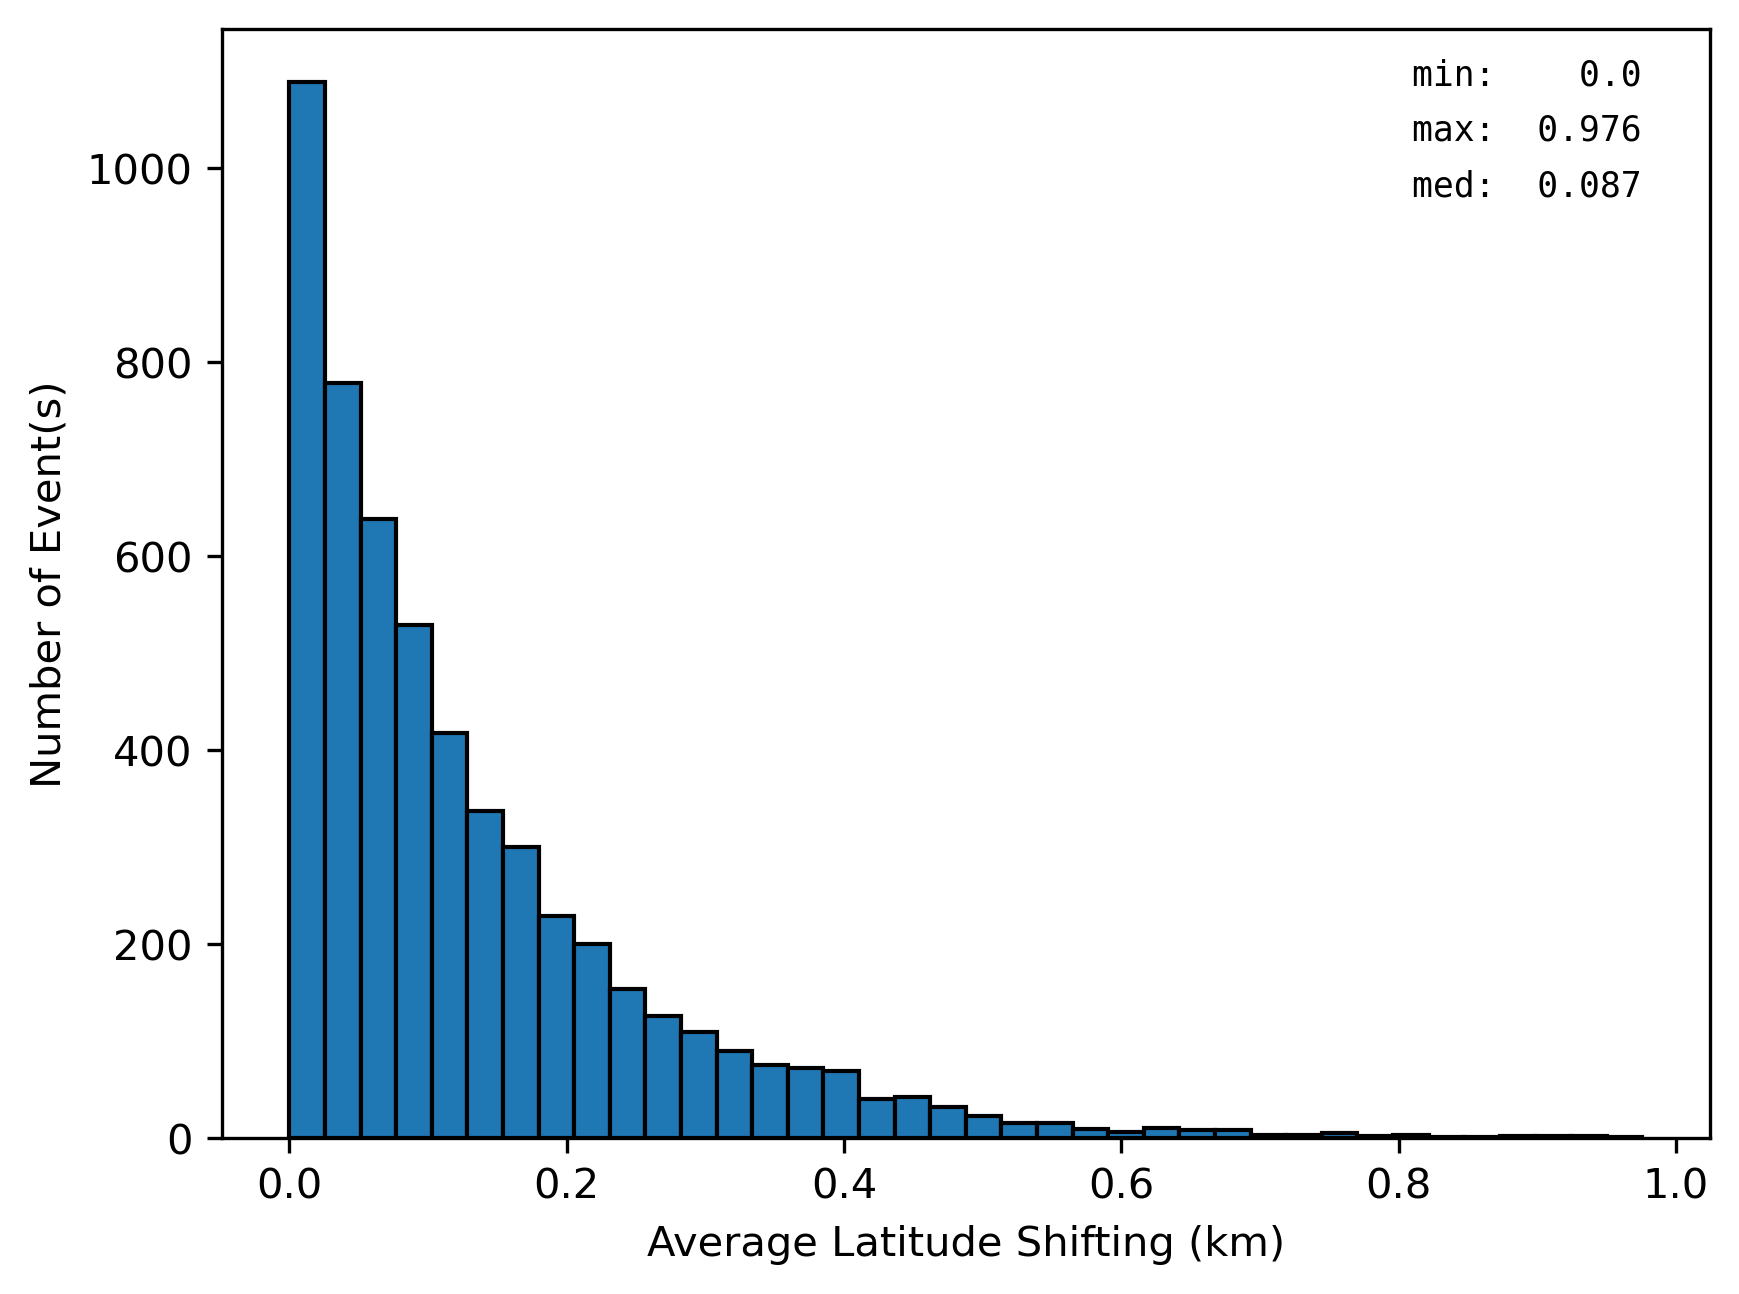

In [15]:
# plotting data to histogram
fig, ax = plt.subplots(dpi = 300)


    
# plot histogram
if absolute_value:
    #calculate min max avg
    max = round(lat_df['avg'].abs().max(),3)
    min = round(lat_df['avg'].abs().min(),3)
    med = round(lat_df['avg'].abs().median(),3)
    ax.hist(lat_df['avg'].abs(),bins='scott',edgecolor='black',align='mid')
else:    
    #calculate min max avg
    max = round(lat_df['avg'].max(),3)
    min = round(lat_df['avg'].min(),3)
    med = round(lat_df['avg'].median(),3)
    ax.hist(lat_df['avg'],bins='scott',edgecolor='black',align='mid')

# plot min max avg
ax.text(0.8,0.95,f"min: {min:>6}", size = "small", family= "monospace", transform=ax.transAxes)
ax.text(0.8,0.90,f"max: {max:>6}", size = "small", family= "monospace", transform=ax.transAxes)
ax.text(0.8,0.85,f"med: {med:>6}", size = "small", family= "monospace", transform=ax.transAxes)

ax.set_xlabel('Average Latitude Shifting (km)')
ax.set_ylabel('Number of Event(s)')
plt.show()

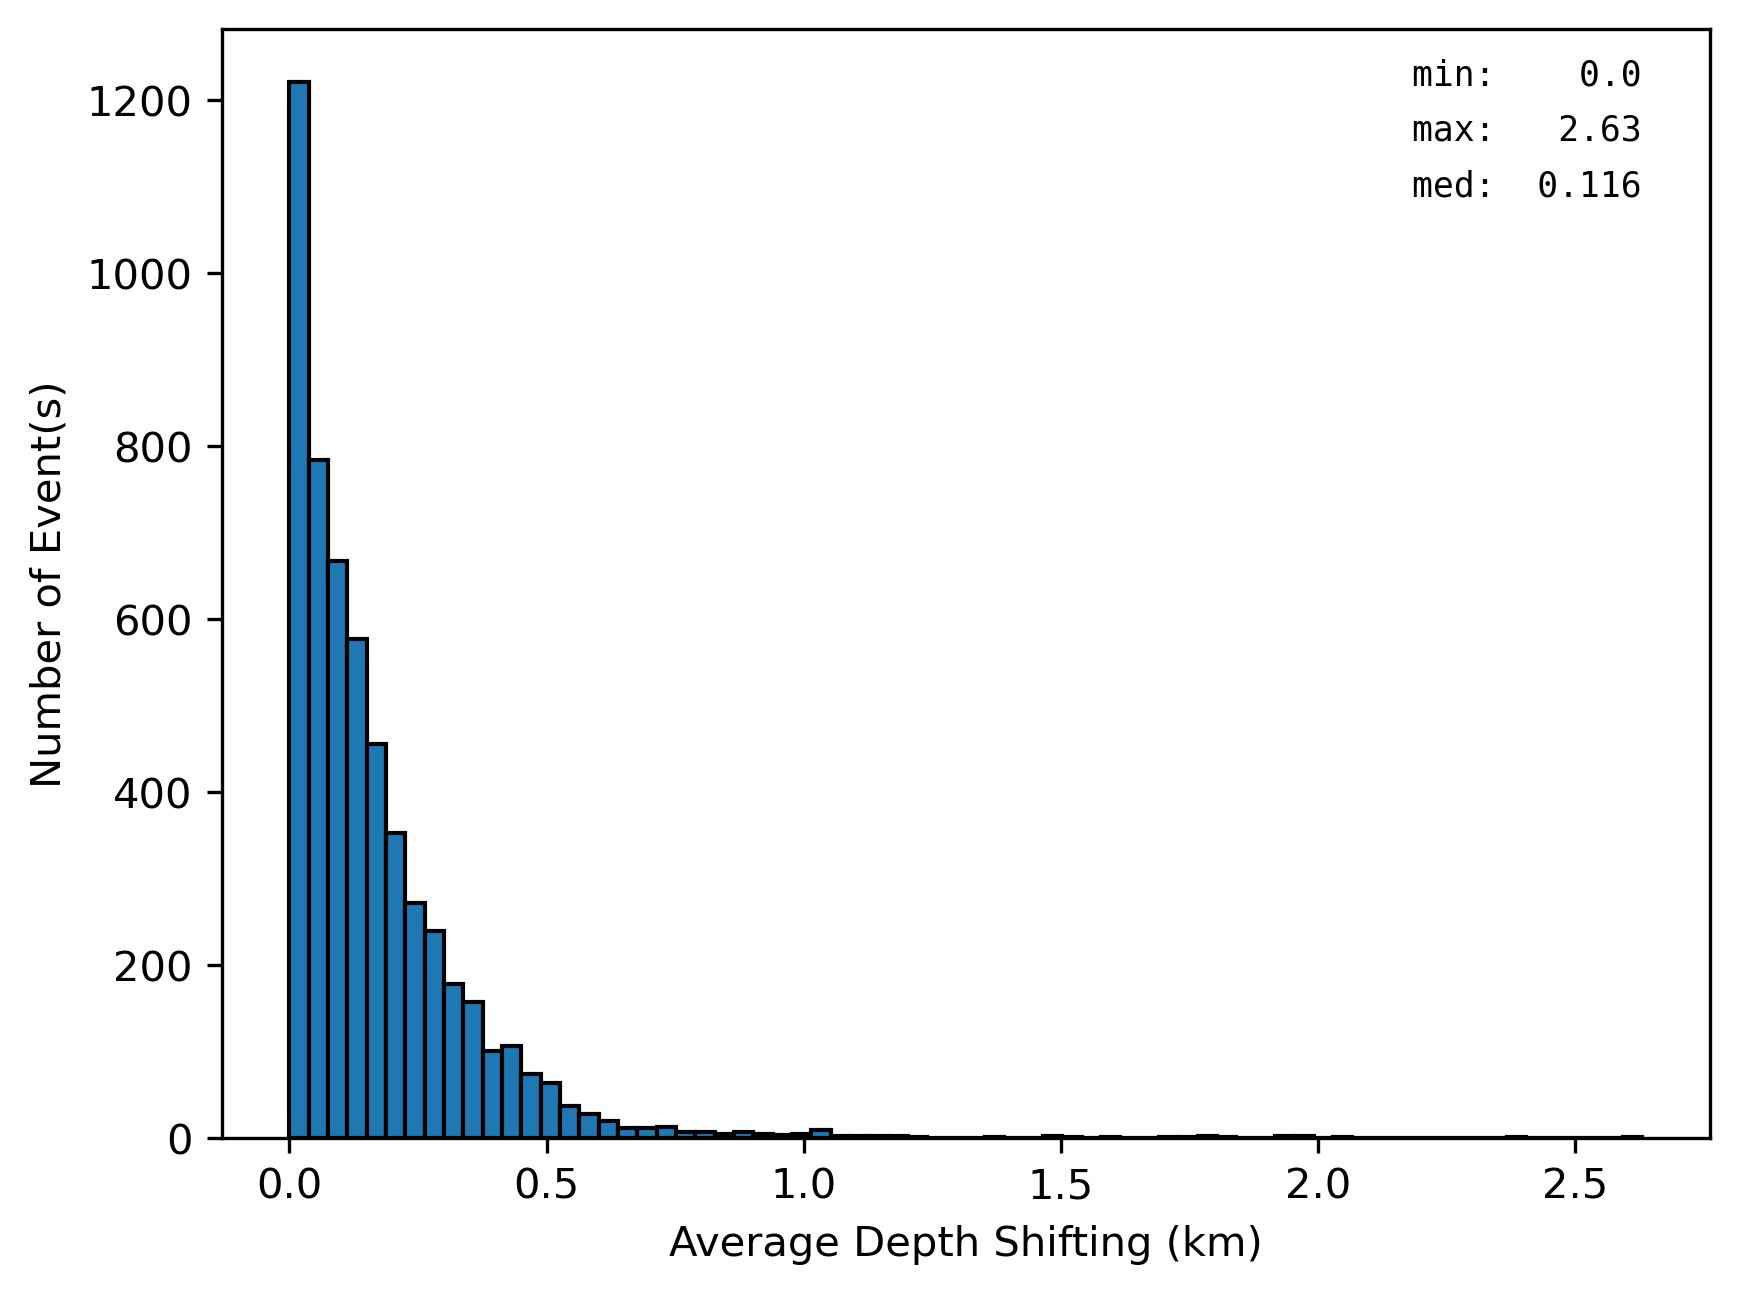

In [16]:
# plotting data to histogram
fig, ax = plt.subplots(dpi = 300)

#calculate min max avg
max = round(depth_df['avg'].max(),3)
min = round(depth_df['avg'].min(),3)
med = round(depth_df['avg'].median(),3)

# plot histogram
if absolute_value:
    #calculate min max avg
    max = round(depth_df['avg'].abs().max(),3)
    min = round(depth_df['avg'].abs().min(),3)
    med = round(depth_df['avg'].abs().median(),3)
    ax.hist(depth_df['avg'].abs(),bins='scott',edgecolor='black',align='mid')
else:
    #calculate min max avg
    max = round(depth_df['avg'].max(),3)
    min = round(depth_df['avg'].min(),3)
    med = round(depth_df['avg'].median(),3)
    ax.hist(depth_df['avg'],bins='scott',edgecolor='black',align='mid')

# plot min max avg
ax.text(0.8,0.95,f"min: {min:>6}", size = "small", family= "monospace", transform=ax.transAxes)
ax.text(0.8,0.90,f"max: {max:>6}", size = "small", family= "monospace", transform=ax.transAxes)
ax.text(0.8,0.85,f"med: {med:>6}", size = "small", family= "monospace", transform=ax.transAxes)

ax.set_xlabel('Average Depth Shifting (km)')
ax.set_ylabel('Number of Event(s)')
plt.show()

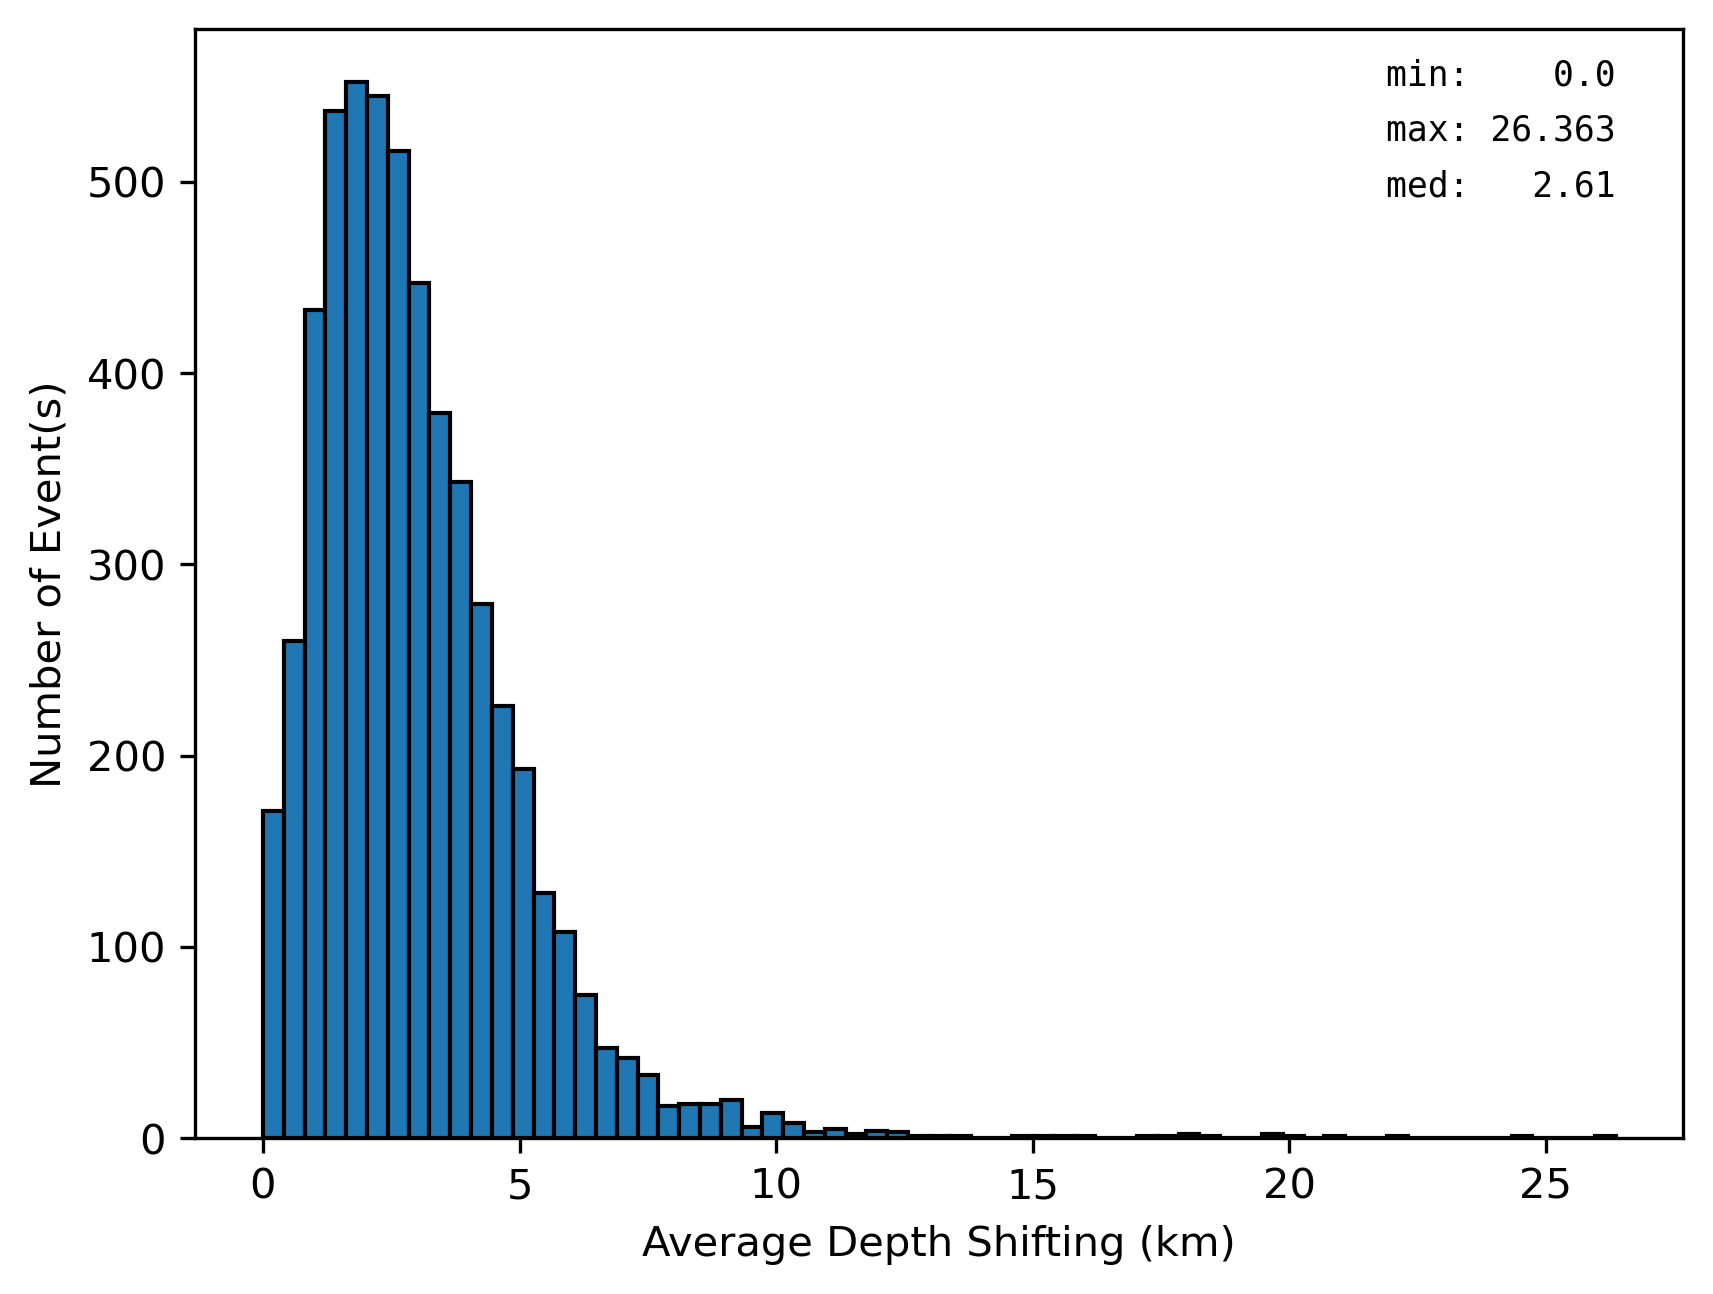

In [10]:
# plotting data to histogram
fig, ax = plt.subplots(dpi = 300)

#calculate min max avg
max = round(df_resultant['res_distance'].max(),3)
min = round(df_resultant['res_distance'].min(),3)
med = round(df_resultant['res_distance'].median(),3)

# plot histogram
if absolute_value:
    #calculate min max avg
    max = round(df_resultant['res_distance'].abs().max(),3)
    min = round(df_resultant['res_distance'].abs().min(),3)
    med = round(df_resultant['res_distance'].abs().median(),3)
    ax.hist(df_resultant['res_distance'].abs(),bins='scott',edgecolor='black',align='mid')
else:
    #calculate min max avg
    max = round(df_resultant['res_distance'].max(),3)
    min = round(df_resultant['res_distance'].min(),3)
    med = round(df_resultant['res_distance'].median(),3)
    ax.hist(df_resultant['res_distance'],bins='scott',edgecolor='black',align='mid')

# plot min max avg
ax.text(0.8,0.95,f"min: {min:>6}", size = "small", family= "monospace", transform=ax.transAxes)
ax.text(0.8,0.90,f"max: {max:>6}", size = "small", family= "monospace", transform=ax.transAxes)
ax.text(0.8,0.85,f"med: {med:>6}", size = "small", family= "monospace", transform=ax.transAxes)

ax.set_xlabel('Average Depth Shifting (km)')
ax.set_ylabel('Number of Event(s)')
plt.show()